# Image Segmentation using Watershed with The Distance Transform

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [2]:
cv2.__version__

'4.5.3'

Notebook based on http://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

Read in "coins" image

In [3]:
img = cv2.imread(os.path.join('data','water_coins.jpg'))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

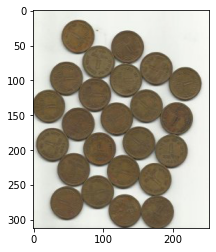

In [4]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

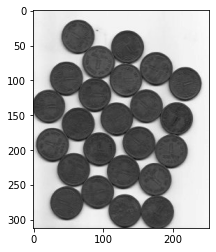

In [5]:
plt.imshow(gray, cmap = 'gray')

Binarize the coins image using Otsu's binarization

In [6]:
thresh, ret = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print(thresh)

162.0


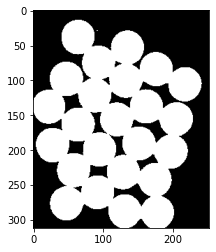

In [7]:
plt.imshow(ret, cmap = 'gray')

Now we need to remove any small white noises in the image. For that we can use morphological opening. To remove any small holes in the object, we can use morphological closing. So, now we know for sure that region near to center of objects are foreground and region much away from the object are background. Only region we are not sure is the boundary region of coins.

In [8]:
 # noise removal
 kernel = np.ones((3,3),np.uint8)
 opening = cv2.morphologyEx(ret,cv2.MORPH_OPEN,kernel, iterations = 2)
  
 # sure background area
 sure_bg = cv2.dilate(opening,kernel,iterations=3)

Here is the sure background

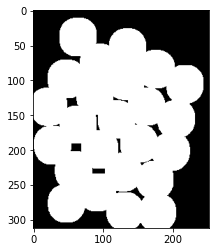

In [9]:
plt.imshow(sure_bg, cmap = 'gray')

Find sure foreground with distance transform

In [10]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

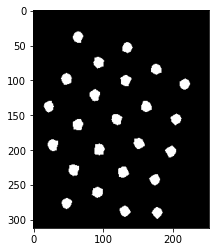

In [11]:
plt.imshow(sure_fg, cmap = 'gray')

Here is the distance transform

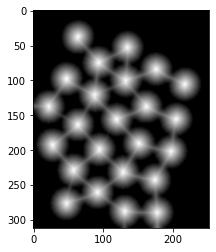

In [12]:
plt.imshow(dist_transform, cmap = 'gray')

Now we know for sure which are region of coins, which are background and all. So we create marker (it is an array of same size as that of original image, but with int32 datatype) and label the regions inside it. The regions we know for sure (whether foreground or background) are labelled with any positive integers, but different integers, and the area we don't know for sure are just left as zero. For this we use cv2.connectedComponents(). It labels background of the image with 0, then other objects are labelled with integers starting from 1.

But we know that if background is marked with 0, watershed will consider it as unknown area. So we want to mark it with different integer. Instead, we will mark unknown region, defined by unknown, with 0.

In [13]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [14]:
# Marker labelling

ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
 
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

See the result shown in JET colormap. The dark blue region shows unknown region. Sure coins are colored with different values. Remaining area which are sure background are shown in lighter blue compared to unknown region.

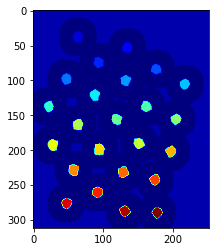

In [15]:
plt.imshow(markers, cmap = 'jet')

Now our marker is ready. It is time for final step, apply watershed. Then marker image will be modified. The boundary region will be marked with -1.

In [16]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

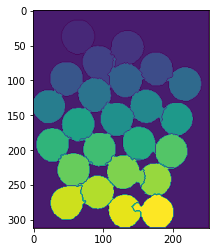

In [17]:
plt.imshow(markers)

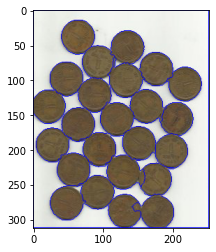

In [18]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))